By [Kevin Michalewicz](https://kevinmichalewicz.com) and [Martin Millon](https://martin-millon.gitlab.io/) on July 2023

This notebook shows how to deconvolve a JWST galaxy image for the F200W band. Before that, the narrow PSF is obtained. It is important to notice that the noise maps are given in this case.

In [1]:
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import pyregion 

from copy import deepcopy
from matplotlib import colors

from starred.deconvolution.deconvolution import Deconv, setup_model
from starred.deconvolution.loss import Loss as decLoss
from starred.deconvolution.parameters import ParametersDeconv
from starred.utils.noise_utils import propagate_noise
from starred.optim.optimization import Optimizer

from starred.plots import plot_function as pltf

from starred.psf.psf import PSF
from starred.psf.loss import Loss
from starred.psf.parameters import ParametersPSF

from starred.utils import ds9reg
from starred.utils.noise_utils import propagate_noise
from starred.procedures.psf_routines import run_multi_steps_PSF_reconstruction


# if running on CPU, might as well use double precision:
from jax.lib import xla_bridge
if not (yourdevice := xla_bridge.get_backend().platform ) == 'gpu':
    import jax
    jax.config.update("jax_enable_x64", True) #we require double digit precision
print(f"You are running on {yourdevice}.")

You are running on cpu.


# STEP 1 : PSF reconstruction

We will reconstruct the PSF, using the high-level function `run_2_steps_PSF_reconstruction` from the `starred.utils.fitting_sequence` module. It will first build an analytical model from a Moffat function and then refine it with regularized pixel grid.

In [2]:
# Parameters
subsampling_factor = 2 #this can be increased fo a better resolution, try 3 or 4 ! 
n_iter_initial = 50
n_iter = 2000 

lambda_scales = 2.0
lambda_hf = 2.0
lambda_positivity = 0. #penalising term if the full psf have negative pixels. Leave it to 0. in most cases to save computationnal time.
include_moffat = True

method1 = 'l-bfgs-b'
method2 = 'adabelief'
data_path = 'data/4_observations'
noise_map_path = 'data/4_obs_noise_maps'
convolution_method = 'fft'

In [3]:
# Data 
file_paths_data = sorted(glob.glob(os.path.join(data_path, 'jwst_f200w_*.npy')))
new_vignets_data = np.array([np.load(f) for f in file_paths_data]) 
N = len(file_paths_data) # number of stars
image_size = np.shape(new_vignets_data)[1] # data dimensions
image_size_up = image_size * subsampling_factor 

In [4]:
# Masking
masks = np.ones((N, image_size, image_size))
for i in range(N):
    possiblemaskfilepath = os.path.join(noise_map_path, 'mask_%s.reg'%str(i))
    if os.path.exists(possiblemaskfilepath):
        print(f'I found a mask for star {i}.')
        r = pyregion.open(possiblemaskfilepath)
        masks[i, :, :] =  1 - r.get_mask(shape=(image_size, image_size)).astype(float)

In [5]:
# Noise map obtention
sigma_paths = sorted(glob.glob(os.path.join(noise_map_path, 'jwst_f200w_*.npy')))
sigma_2 = np.array([np.load(f) for f in sigma_paths]) ** 2

#Renormalise your data and the noise maps by the max of the first image. Works better when using adabelief
norm = new_vignets_data[0].max() / 100.
new_vignets_data /= norm
sigma_2 /= norm**2

(3, 32, 32)


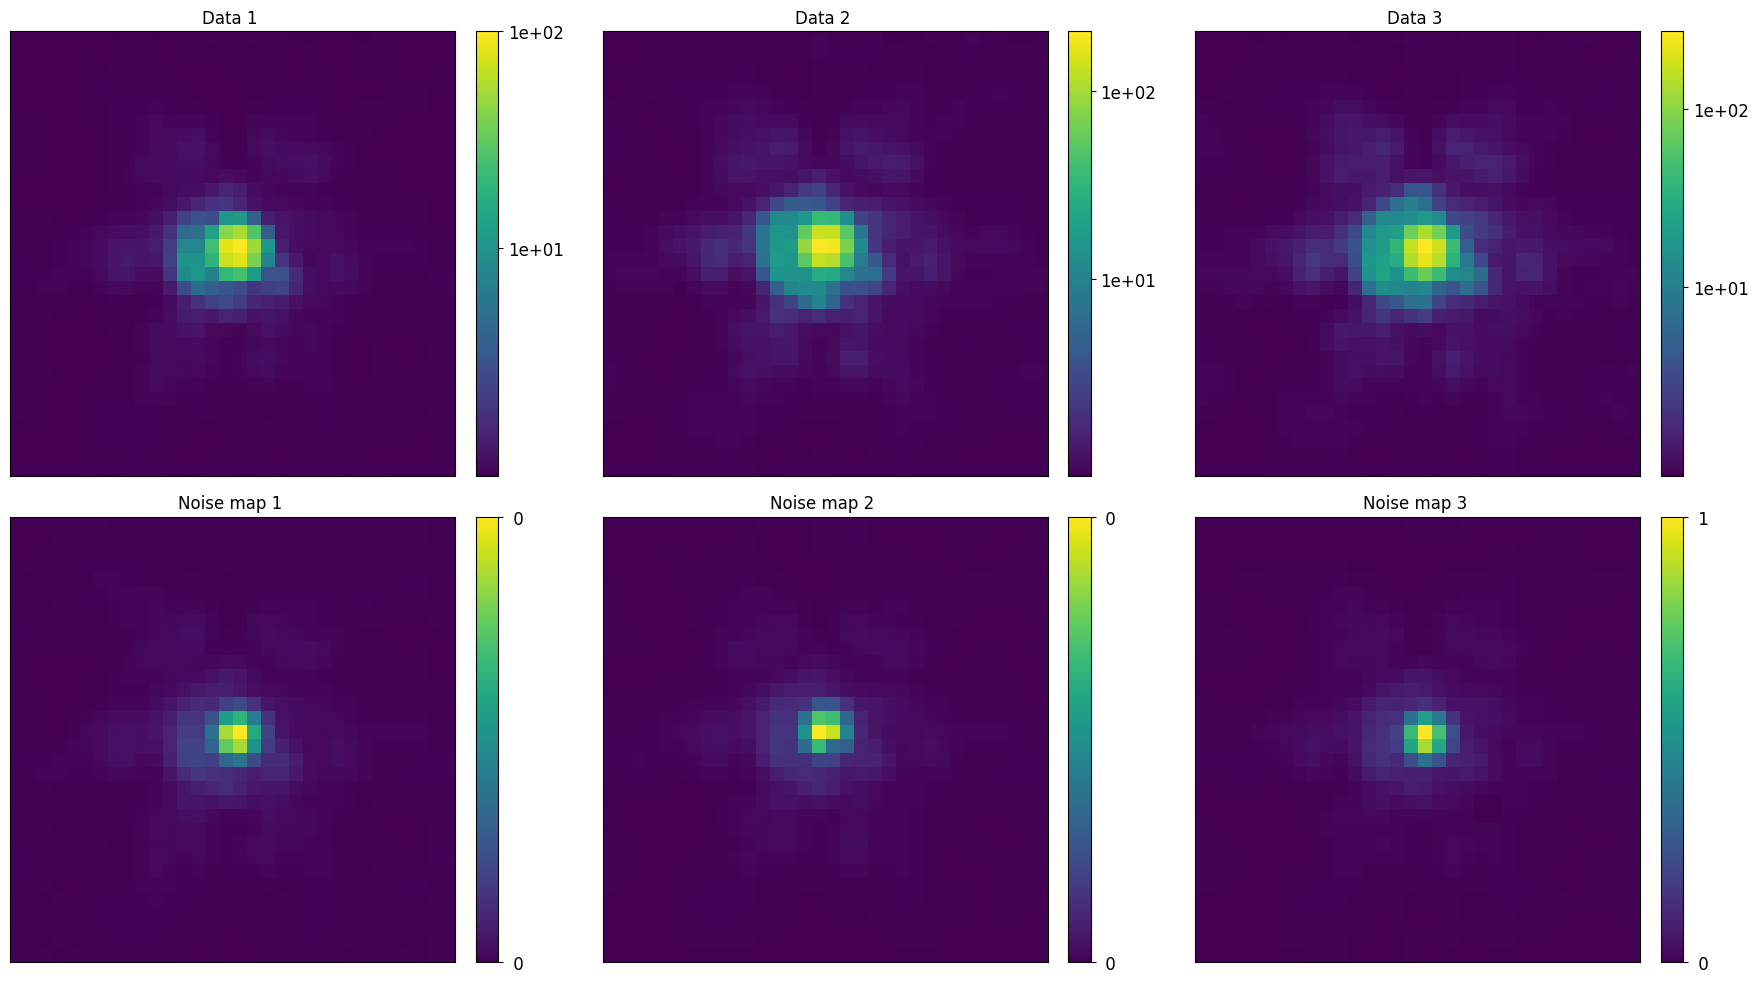

In [6]:
print(np.shape(new_vignets_data))
fig = pltf.display_data(new_vignets_data, sigma_2 = sigma_2)

In [7]:
# Build the PSF model class
model = PSF(image_size=image_size, number_of_sources=N, 
            upsampling_factor=subsampling_factor, 
            convolution_method=convolution_method,
            include_moffat = include_moffat)

# Parameter initialization. 
kwargs_init, kwargs_fixed, kwargs_up, kwargs_down = model.smart_guess(new_vignets_data, fixed_background=False)

print('Initial Guess :', kwargs_init) 

parameters = ParametersPSF(kwargs_init, kwargs_fixed, kwargs_up=kwargs_up, kwargs_down=kwargs_down)

Initial Guess : {'kwargs_moffat': {'fwhm': 3.0, 'beta': 2.0, 'C': 149.12380012049093}, 'kwargs_gaussian': {'a': Array([ 95.35240062, 162.10458852, 189.91442578], dtype=float64), 'x0': array([-0.08397102, -0.24713516,  0.19010353]), 'y0': array([0.02102089, 0.30672264, 0.14050484])}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64)}}


In [8]:
# PSF fitting: 
kwargs_lbfgs = {'maxiter':n_iter_initial}
kwargs_optax = {'max_iterations':n_iter, 'progress_bar':True}

model, parameters, loss, kwargs_partial_list, LogL_list, loss_history_list = run_multi_steps_PSF_reconstruction(new_vignets_data, model, parameters, sigma_2, lambda_scales=lambda_scales,
                                                                                                                lambda_hf = lambda_hf, lambda_positivity=lambda_positivity, 
                                                                                                                method_noise = 'MC', optim_list=['l-bfgs-b', 'adabelief'],
                                                                                                                kwargs_optim_list = [kwargs_lbfgs, kwargs_optax]) 

kwargs_final = kwargs_partial_list[-1]

### Step 1, fixing : ['background'] ###


/Users/martin/Desktop/modules/starred/starred/utils/noise_utils.py:52: RuntimeWarning: Mean of empty slice
  noise_map = np.nanmean(centered_masked_noise_maps, axis=0)


Step 1/2 took  4 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm': Array([2.], dtype=float64), 'beta': Array([1.14072753], dtype=float64), 'C': Array([149.12380012], dtype=float64)}, 'kwargs_gaussian': {'a': Array([ 74.07774972, 128.17237373, 147.86332438], dtype=float64), 'x0': Array([-0.08070778, -0.30833272,  0.14890227], dtype=float64), 'y0': Array([0.09014383, 0.26103832, 0.1248926 ], dtype=float64)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64)}}
LogL :  1701852.1615547452
Overall Reduced Chi2 :  3323.9300030366117
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|██████████| 2000/2000 [00:09<00:00, 213.85it/s]


Step 2/2 took 10 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm': Array([2.], dtype=float64), 'beta': Array([1.14072753], dtype=float64), 'C': Array([149.12380012], dtype=float64)}, 'kwargs_gaussian': {'a': Array([115.7554588 , 199.24337916, 224.76192899], dtype=float64), 'x0': Array([ 0.23099535, -0.05717481,  0.52546818], dtype=float64), 'y0': Array([0.22827771, 0.50901824, 0.18188059], dtype=float64)}, 'kwargs_background': {'background': Array([1.82229779, 0.31573924, 0.27415301, ..., 0.14279227, 0.1745525 ,
       0.16654689], dtype=float64)}}
LogL :  163795.6389142727
Overall Reduced Chi2 :  260.8611509504431


Moffat fit :


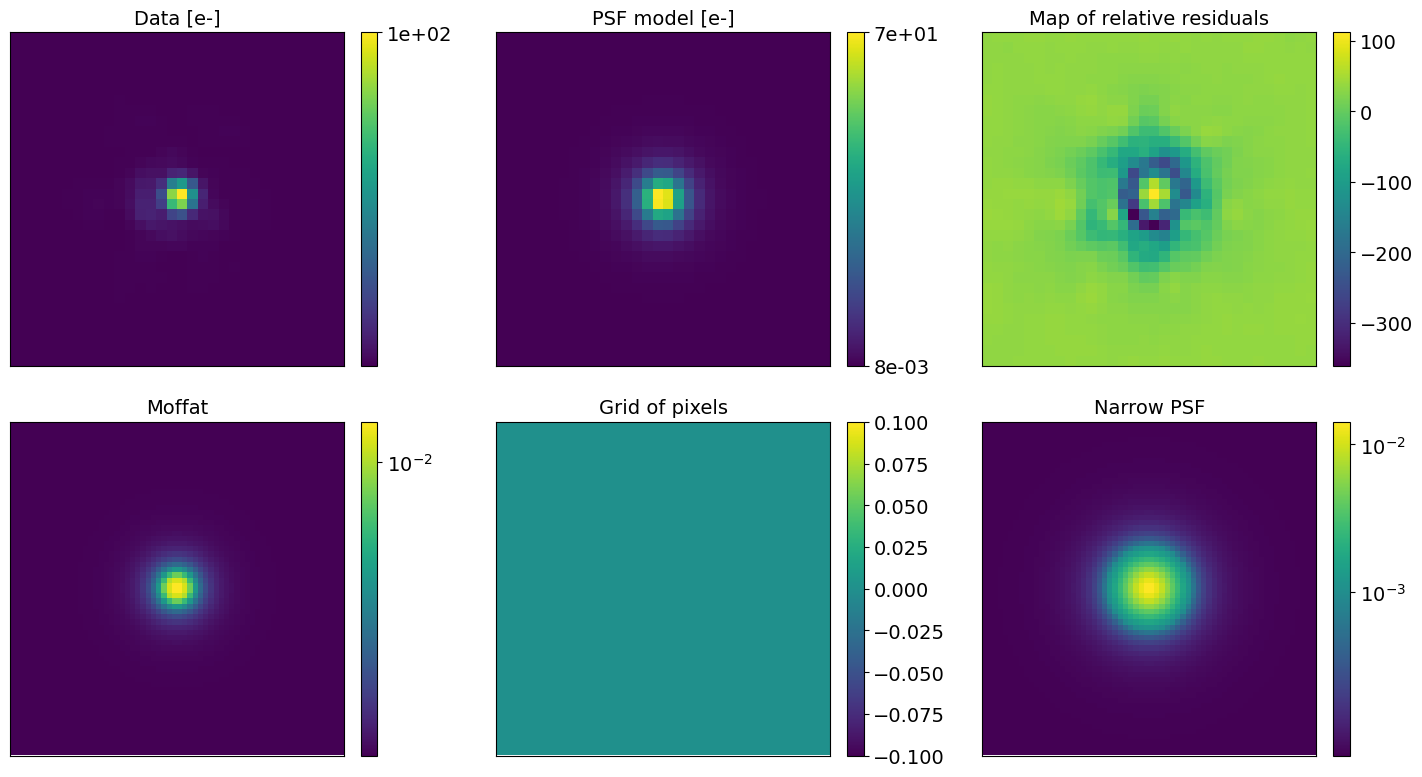

Moffat+ Background fit :


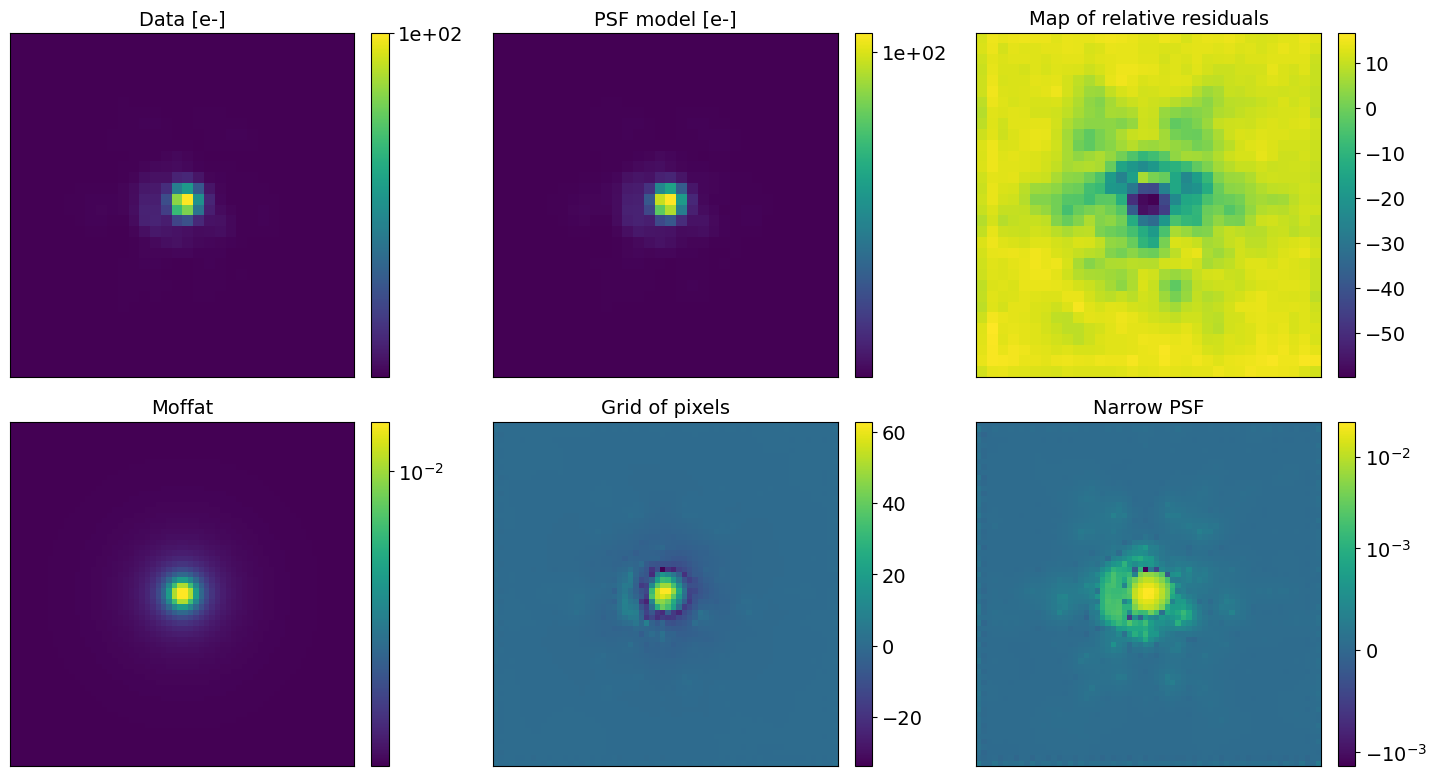

Multiple stars PSF model :


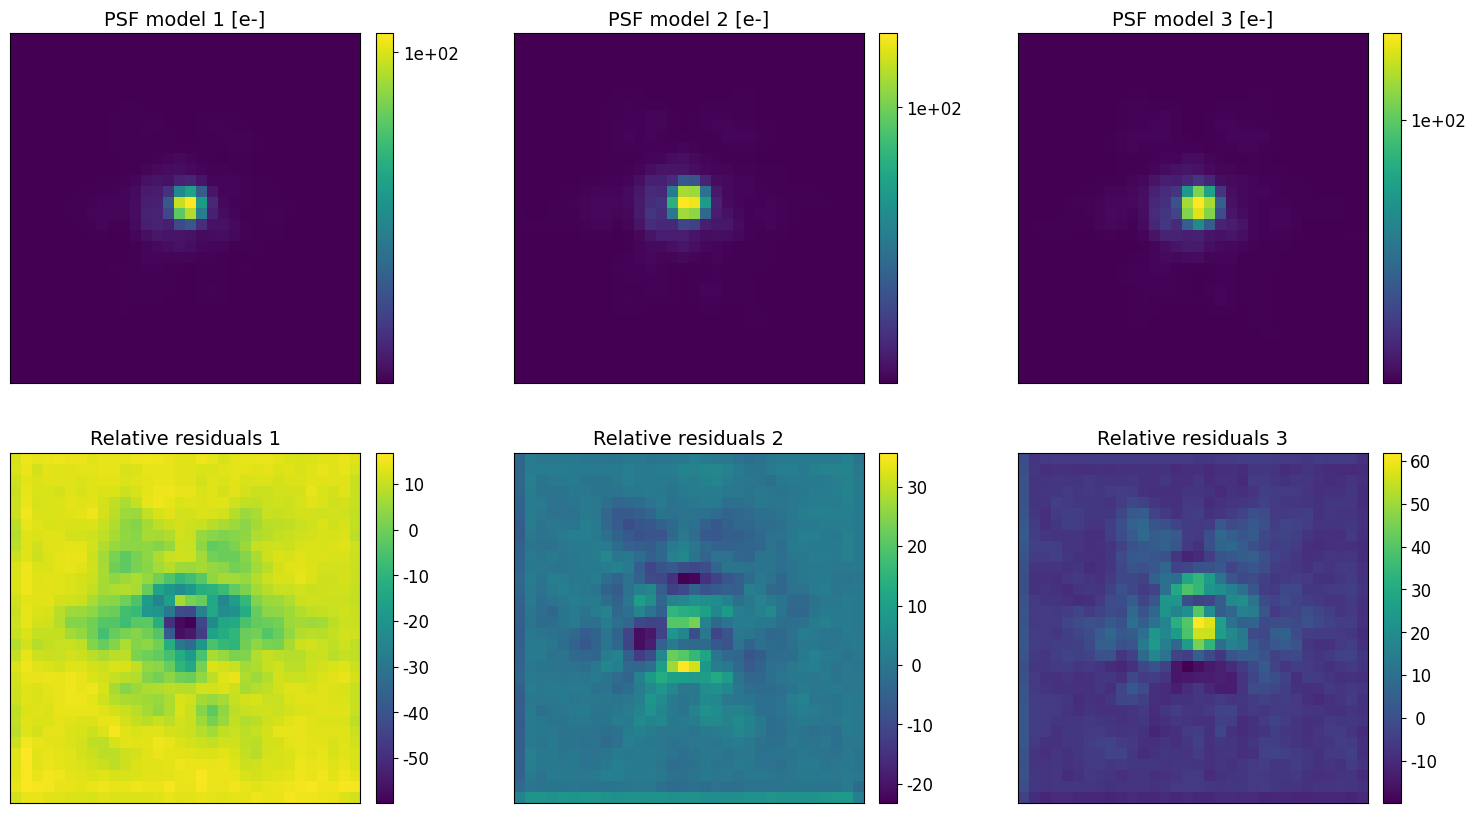

Loss history :


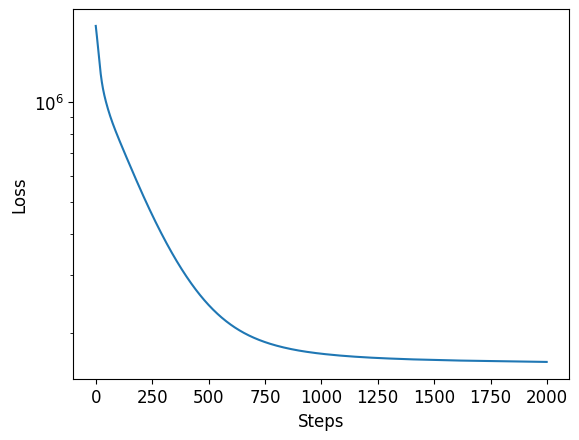

In [9]:
fig1 = pltf.single_PSF_plot(model, new_vignets_data, sigma_2, kwargs_partial_list[0], n_psf=0, units='e-')
print('Moffat fit :')
plt.show(fig1)
fig2 = pltf.single_PSF_plot(model, new_vignets_data, sigma_2, kwargs_final, n_psf=0, units='e-')
print('Moffat+ Background fit :')
plt.show(fig2)
fig3 = pltf.multiple_PSF_plot(model,new_vignets_data, sigma_2, kwargs_final, units='e-')
print('Multiple stars PSF model :')
plt.show(fig3)

fig, ax = plt.subplots(1,1)
ax.plot(range(len(loss_history_list[-1])), loss_history_list[-1])
ax.set_xlabel('Steps')
ax.set_ylabel('Loss')
ax.set_yscale('log')
print('Loss history :')
plt.show(fig)

In [10]:
# Example on how to retrieve different elements of the PSF 
n_psf = 0
estimated_full_psf = model.model(**kwargs_final)[n_psf]
estimated_full_psf_hf = model.model(**kwargs_final, high_res=True)[n_psf]
analytic = model.get_moffat(kwargs_final['kwargs_moffat'], norm=True)
s = model.get_narrow_psf(**kwargs_final, norm=True)
background = model.get_background(kwargs_final['kwargs_background'])

dif = new_vignets_data[n_psf,:,:] - estimated_full_psf
rr = np.abs(dif) / np.sqrt(sigma_2[n_psf,:,:])

# STEP 2 : image deconvolution

From the reconstructed narrow PSF, we now deconvolve the image. 

In [11]:
# Parameters
epochs = 1 #number of epochs
n_iter = 1000
M = 0 #number of point source
method_deconv = 'adabelief'
lambda_scales = 1
lambda_hf = 1000
data_path = 'data/4_galaxy_observation'
noise_map_path = 'data/4_galaxy_noise_map'

In [12]:
# Retrieving data
file_paths = sorted(glob.glob(os.path.join(data_path, '*f200w*.npy')))
data = np.array([np.load(f) for f in file_paths])/1.

im_size = np.shape(data)[1]
im_size_up = im_size * subsampling_factor

print('Data shape:', data.shape)

# PSF reshaping
s = s.reshape(epochs, s.shape[-1], s.shape[-1])
print('Narrow PSF shape:', s.shape)

# Noise map 
sigma_paths = sorted(glob.glob(os.path.join(noise_map_path, '*f200w*.npy')))
sigma_2 = np.array([np.load(f) for f in sigma_paths]) ** 2



Data shape: (1, 80, 80)
Narrow PSF shape: (1, 64, 64)


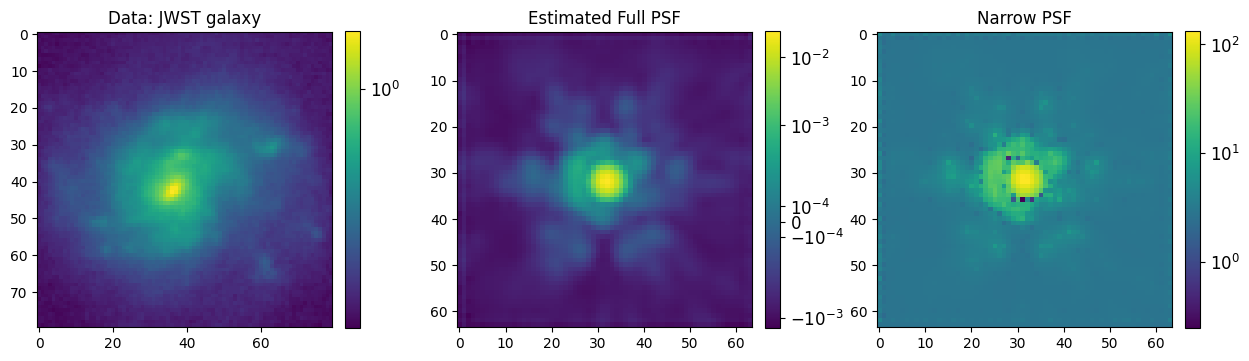

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15,15))
plt.subplots_adjust(wspace=0.3)
fraction = 0.046
pad = 0.04

plt.rc('font', size=12)           
axs[0].set_title('Data: JWST galaxy', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[2].set_title('Narrow PSF', fontsize=12)
axs[2].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_title('Estimated Full PSF', fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=10)

fig.colorbar(axs[0].imshow(data[0,:,:], norm=colors.SymLogNorm(linthresh=5e-4)), ax=axs[0], fraction=fraction, pad=pad)
fig.colorbar(axs[2].imshow(s[0,:,:], norm=colors.SymLogNorm(linthresh=5e-4)), ax=axs[1], fraction=fraction, pad=pad)
fig.colorbar(axs[1].imshow(estimated_full_psf_hf, norm=colors.SymLogNorm(linthresh=5e-4)), ax=axs[2], fraction=fraction, pad=pad)
plt.show()

In [14]:
# Parameter initialization
initial_c_x = np.array([]) 
initial_c_y = np.array([]) 

model, kwargs_init, kwargs_up, kwargs_down, kwargs_fixed = setup_model(data, 
                                                                       sigma_2, 
                                                                       s, 
                                                                       initial_c_x,
                                                                       initial_c_y, 
                                                                       subsampling_factor)

parameters = ParametersDeconv(kwargs_init, 
                              kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)


In [15]:
# compute noise level in starlet space
W = propagate_noise(model, np.sqrt(sigma_2), kwargs_init, wavelet_type_list=['starlet'], 
                    method='MC', num_samples=500, seed=1, likelihood_type='chi2', 
                    verbose=False, upsampling_factor=subsampling_factor)[0]

loss = decLoss(data, model, parameters, sigma_2, 
               regularization_terms='l1_starlet', 
               regularization_strength_scales=lambda_scales, 
               regularization_strength_hf=lambda_hf, W=W) 


In [16]:
optim = Optimizer(loss, parameters, method=method_deconv )
best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(max_iterations=n_iter, restart_from_init=True, init_learning_rate=1e-3) 

optax.adabelief: 100%|██████████| 1000/1000 [00:32<00:00, 30.91it/s]


{'kwargs_analytic': {'a': Array([], dtype=float64), 'c_x': Array([], dtype=float64), 'c_y': Array([], dtype=float64), 'dx': Array([0.], dtype=float64), 'dy': Array([0.], dtype=float64), 'alpha': Array([0.], dtype=float64)}, 'kwargs_background': {'mean': Array([0.03930911], dtype=float64), 'h': Array([-0.02697279, -0.01703792, -0.01112114, ..., -0.00977049,
       -0.01648544, -0.02651865], dtype=float64)}, 'kwargs_sersic': {'amp': Array([], dtype=float64), 'R_sersic': Array([], dtype=float64), 'n_sersic': Array([], dtype=float64), 'center_x': Array([], dtype=float64), 'center_y': Array([], dtype=float64), 'e1': Array([], dtype=float64), 'e2': Array([], dtype=float64)}}


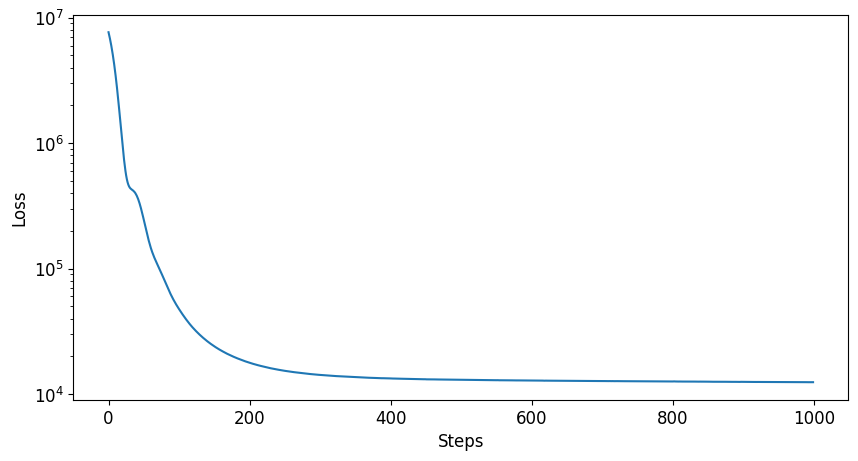

In [17]:
# Printing final results
kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))
print(kwargs_final)
fig = pltf.plot_loss(extra_fields['loss_history'])



In [18]:
# Retrieving different elements of the deconvolved image
epoch = 0
output = model.model(kwargs_final)[epoch]
deconv, h = model.getDeconvolved(kwargs_final, epoch)

data_show = data[epoch,:,:] 

dif = data_show - output
rr = np.abs(dif) / np.sqrt(sigma_2[epoch,:,:])

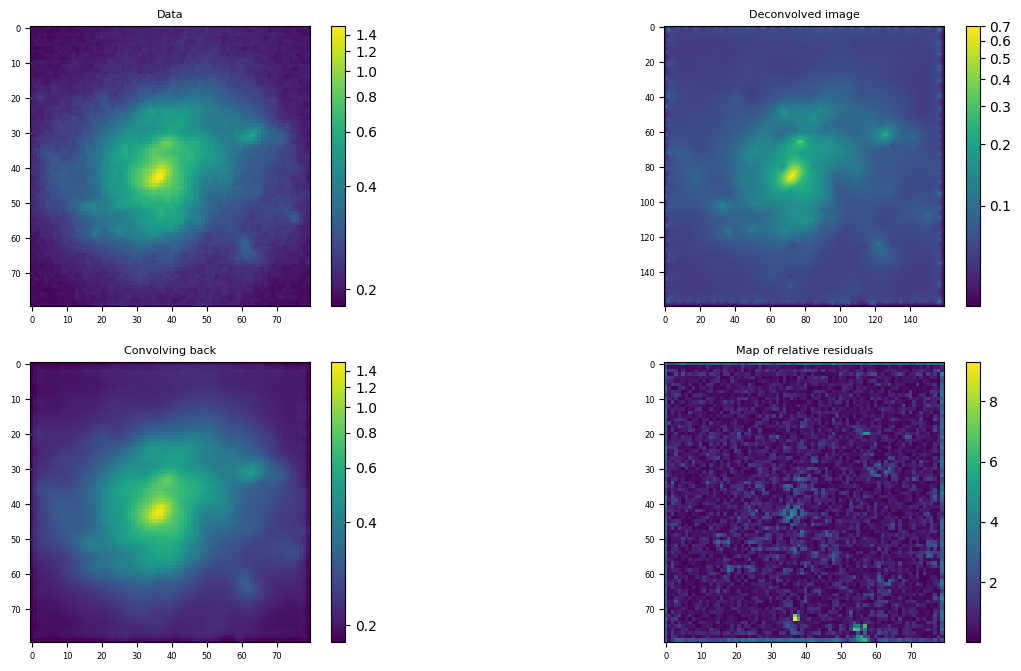

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15,8))
fraction = 0.046
pad = 0.04
font_size = 10
ticks_size = 6

from astropy.visualization import (imshow_norm, MinMaxInterval,
                                   SqrtStretch, AsinhStretch)
stretch = AsinhStretch

plt.rc('font', size=font_size)           
axs[0,0].set_title('Data', fontsize=8)
axs[0,0].tick_params(axis='both', which='major', labelsize=ticks_size)

axs[0,1].set_title('Deconvolved image', fontsize=8)
axs[0,1].tick_params(axis='both', which='major', labelsize=ticks_size)

axs[1,0].set_title('Convolving back', fontsize=8)
axs[1,0].tick_params(axis='both', which='major', labelsize=ticks_size)

axs[1,1].set_title('Map of relative residuals', fontsize=8)
axs[1,1].tick_params(axis='both', which='major', labelsize=ticks_size)


im, norm = imshow_norm(data_show, axs[0,0], interval=MinMaxInterval(), stretch=stretch())
fig.colorbar(im, ax=axs[0,0], fraction=fraction, pad=pad)
im2, _ = imshow_norm(h, axs[0,1], interval=MinMaxInterval(), stretch=stretch())
fig.colorbar(im2, ax=axs[0,1], fraction=fraction, pad=pad)
fig.colorbar(axs[1,0].imshow(output, norm=norm), ax=axs[1,0], fraction=fraction, pad=pad)
fig.colorbar(axs[1,1].imshow(rr), ax=axs[1,1], fraction=fraction, pad=pad) 
plt.show()

In [20]:
input_flux = data.sum()
output_flux = output.sum()

print('Data flux: ' + str(input_flux))
print('Deconvolved image flux: ' + str(output_flux))
print('Flux change: ' + str(100 * abs(input_flux-output_flux) / input_flux) + '%')

print('Overall Reduced Chi2 : ', loss.reduced_chi2(kwargs_final))

Data flux: 1947.2152
Deconvolved image flux: 1943.771185126359
Flux change: 0.1768692447019096%
Overall Reduced Chi2 :  1.232188783170871


In [21]:
#save results 
#from starred.utils.generic_utils import save_fits

#output_path = Path('./output/JWST')
#output_path.mkdir(parents=1, exist_ok=1)
#model.export(output_path, kwargs_final, data, sigma_2, format='fits')